In [317]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import torch.distributions as tdist

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax
from scipy.stats import norm
# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [318]:
# matplotlib options
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

Fraction of boundary cases: 0.019
Fraction of problematic cases: 0.010


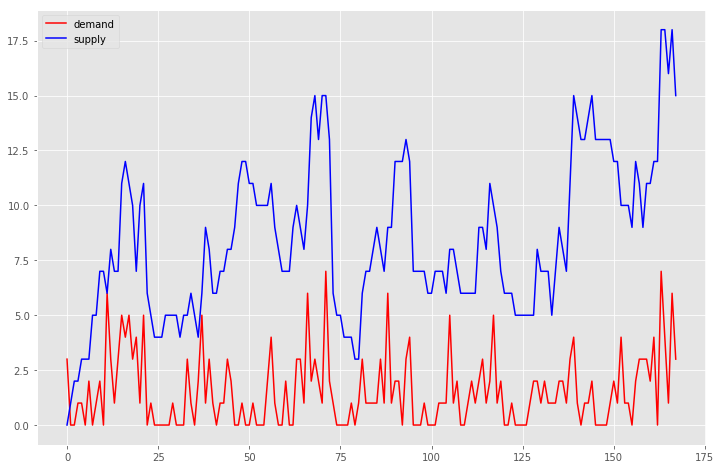

In [319]:
#Read in the pre-processed data
df = pd.read_csv('prepared/demand_supply/10244.csv')
#Baseline
df.time = pd.to_datetime(df.time)
demand_ts = [df.demand[t] for t in range(len(df))]
supply_ts = [df.supply[t] for t in range(len(df))]
print("Fraction of boundary cases: %.3f" % (np.sum(np.array(demand_ts) == np.array(supply_ts)) / len(demand_ts)),)
print("Fraction of problematic cases: %.3f" % (np.sum(np.array(demand_ts) > np.array(supply_ts)) / len(demand_ts)),)
plt.plot(demand_ts[:(24*7)], "r-")
plt.plot(supply_ts[:(24*7)], "b-")
plt.legend(["demand", "supply"], loc="upper left")
plt.show()

A boundary case is our censored problem.
A problematic case is a situation, where more pickups than supply is registered. This is probably in the beginning of the data, where the supply could not be tracked. Therefore the best we can do is to se supply = demand for those time-slots

In [320]:
for i in range(df.shape[0]):
    if df.demand[i] > df.supply[i]:
        df.supply[i] = df.demand[i]

C:\Users\marti\AppData\Local\conda\conda\envs\sandbox\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


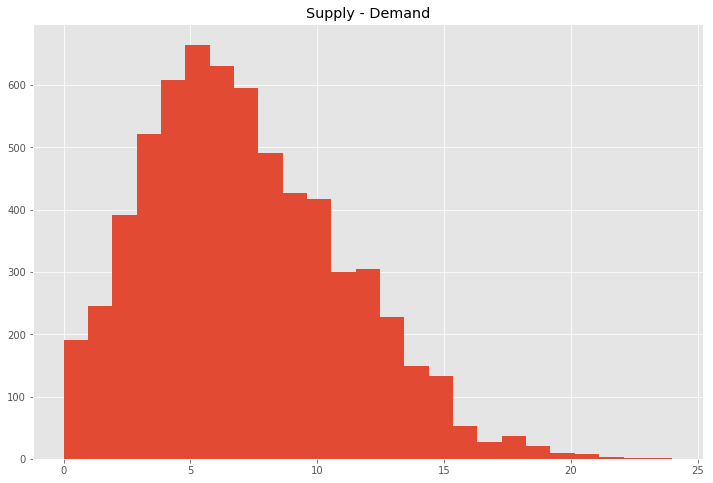

In [321]:
#"(df.supply-df.demand).hist(bins = 25)
plt.hist(df.supply-df.demand, bins = 25);
plt.title("Supply - Demand")
plt.show()

In [322]:
dim = df.shape[0]

ToD = [df.time[i].hour for i in range(dim)]
DoW = [df.time[i].weekday() for i in range(dim)]
DoM = [df.time[i].day for i in range(dim)]
Month = [df.time[i].month for i in range(dim)]
df['ToD'] = ToD
df['DoW'] = DoW
df['DoM'] = DoM
df['Month'] = Month

In [323]:
df = df[['Month','DoM','DoW','ToD','demand','supply']].sort_values(['Month', 'DoM','DoW','ToD']).reset_index(drop=True)
Days = ['Mon', 'Tue','Wed','Thu','Fri','Sat','Sun']
df.DoW = [Days[each] for each in df.DoW]
#Converting to categorical - the month and date is excluded for now
df = pd.concat([df, pd.get_dummies(df.DoW), pd.get_dummies(df.ToD)], axis = 1)
df.head()

,Month,DoM,DoW,ToD,demand,supply,Fri,Mon,Sat,Sun,...,14,15,16,17,18,19,20,21,22,23
0,1,1,Mon,0,5,15,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,Mon,1,3,11,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,1,Mon,2,0,9,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,Mon,3,1,9,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,Mon,4,1,9,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [324]:
X = df.iloc[:,6:]
y = df.demand
z = df.supply

To establish a baseline, we can do a simple linear regression, using the Sklearn package

In [326]:
reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.32440167475155457

In [327]:
#Prepare data for training
X = np.asarray(X)
y = np.asarray(y)
z = np.asarray(z)

obs, num_features = X.shape
train_idx, val_idx = int(obs*0.8), int(obs*0.9)
x_train = X[:train_idx,:].astype('float32')
targets_train = y[:train_idx].astype('float32')
supply_train = z[:train_idx].astype('float32')

x_valid = X[train_idx:val_idx,:].astype('float32')
targets_valid = y[train_idx:val_idx].astype('float32')

x_test = X[val_idx:,:].astype('float32')
targets_test = y[val_idx:].astype('float32')

In [328]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

In [329]:
hidden = 126

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.hidden = Linear(in_features=num_features, out_features=hidden, bias=True)
        self.out = Linear(in_features=hidden, out_features = 1)
        
    def forward(self, x):
        
        x = relu(self.hidden(x))
        x = relu(self.out(x))
        
        return x

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (hidden): Linear(in_features=31, out_features=126)
  (out): Linear(in_features=126, out_features=1)
)


In [330]:
import math
def standard_normal_pdf(x):
    
    return (1/math.sqrt(2 * math.pi))*torch.exp(-x**2/2)
    

def standard_normal_cdf(x):
    return 0.5 * (1 + torch.erf(x / math.sqrt(2)))


#Lets define our own loss!

def NLL(output, labels):
    x = torch.squeeze(output)
    return -torch.log(standard_normal_pdf(labels- x)).sum()

## Lets train our model with the standard Mean Squred Loss function

In [331]:
model = Net()

criterion = nn.MSELoss()# Mean Squared Loss 
l_rate = 0.001
optimiser = torch.optim.Adam(model.parameters(), lr = l_rate) #Stochastic Gradient Descent

epochs = 1000

In [332]:
val_acc = []
train_acc = []

for epoch in range(epochs):

    epoch +=1
    #increase the number of epochs by 1 every time

    inputs = Variable(torch.from_numpy(x_train))
    labels = Variable(torch.from_numpy(targets_train))

    #clear grads as discussed in prev post

    optimiser.zero_grad()

    #forward to get predicted values

    outputs = model.forward(inputs)
    loss = criterion(outputs, labels)
    loss.backward()# back props
    optimiser.step()# update the parameters
    
    
    predicted = get_numpy(model.forward(Variable(torch.from_numpy(x_train))))
    predicted_val = get_numpy(model.forward(Variable(torch.from_numpy(x_valid))))
    
    train_acc.append(r2_score(targets_train, predicted))
    val_acc.append(r2_score(targets_valid, predicted_val))
    
    print('epoch {}, loss {}, train acc {}, val acc {}'.format(epoch,loss.data[0], train_acc[epoch-1], val_acc[epoch-1]))

epoch 1, loss 7.956584930419922, acc -1.067416093915753
epoch 2, loss 7.894257545471191, acc -1.0489245870274555
epoch 3, loss 7.823632717132568, acc -1.029671073927931
epoch 4, loss 7.750108242034912, acc -1.0091288372146985
epoch 5, loss 7.6717047691345215, acc -0.9880272457778572
epoch 6, loss 7.591106414794922, acc -0.9666750509362347
epoch 7, loss 7.50956916809082, acc -0.9451629456839306
epoch 8, loss 7.427427291870117, acc -0.923677390190923
epoch 9, loss 7.345399856567383, acc -0.9022088565575936
epoch 10, loss 7.263411521911621, acc -0.8807692954197446
epoch 11, loss 7.181545257568359, acc -0.8593538815981407
epoch 12, loss 7.099786281585693, acc -0.8379494849728013
epoch 13, loss 7.018055438995361, acc -0.8165376262206894
epoch 14, loss 6.936310768127441, acc -0.7951312940776052
epoch 15, loss 6.854562759399414, acc -0.7737431108331749
epoch 16, loss 6.772879123687744, acc -0.7523913155795319
epoch 17, loss 6.6913533210754395, acc -0.731056139144107
epoch 18, loss 6.609889984

epoch 146, loss 2.5937836170196533, acc 0.3215514982971224
epoch 147, loss 2.5905957221984863, acc 0.32236529909778744
epoch 148, loss 2.587489128112793, acc 0.3231594678343708
epoch 149, loss 2.5844545364379883, acc 0.32393590729417954
epoch 150, loss 2.581498146057129, acc 0.3246944785714341
epoch 151, loss 2.578599214553833, acc 0.32543484033734493
epoch 152, loss 2.575756311416626, acc 0.32615681044874534
epoch 153, loss 2.573007822036743, acc 0.3268617724348988
epoch 154, loss 2.5703272819519043, acc 0.32755030342760616
epoch 155, loss 2.567687511444092, acc 0.32822248306407076
epoch 156, loss 2.5651257038116455, acc 0.32887932106848294
epoch 157, loss 2.5626118183135986, acc 0.3295203735418525
epoch 158, loss 2.5601706504821777, acc 0.33014491656358524
epoch 159, loss 2.557779550552368, acc 0.3307526900224742
epoch 160, loss 2.5554585456848145, acc 0.3313467847438425
epoch 161, loss 2.5531938076019287, acc 0.33192905358913694
epoch 162, loss 2.55096435546875, acc 0.33249845153334

epoch 289, loss 2.4038472175598145, acc 0.3707250873948169
epoch 290, loss 2.4028308391571045, acc 0.37099157657371695
epoch 291, loss 2.4018161296844482, acc 0.3712582092959763
epoch 292, loss 2.400794744491577, acc 0.3715265793990654
epoch 293, loss 2.399777412414551, acc 0.3717923905989494
epoch 294, loss 2.398763418197632, acc 0.37205997042321803
epoch 295, loss 2.3977324962615967, acc 0.372329435188995
epoch 296, loss 2.3967063426971436, acc 0.37259900004578017
epoch 297, loss 2.3956780433654785, acc 0.37286786073234024
epoch 298, loss 2.39465069770813, acc 0.3731377090196071
epoch 299, loss 2.393616199493408, acc 0.37341007819429917
epoch 300, loss 2.3925750255584717, acc 0.37368332734101695
epoch 301, loss 2.391533851623535, acc 0.3739542706349791
epoch 302, loss 2.3905091285705566, acc 0.3742252808709704
epoch 303, loss 2.389465093612671, acc 0.37449379177021447
epoch 304, loss 2.3884360790252686, acc 0.37476190905234696
epoch 305, loss 2.3874220848083496, acc 0.375028958738279

epoch 433, loss 2.290820837020874, acc 0.40017093865455766
epoch 434, loss 2.2903902530670166, acc 0.40028141529129924
epoch 435, loss 2.289973735809326, acc 0.4003897860276322
epoch 436, loss 2.28955340385437, acc 0.4004978293596524
epoch 437, loss 2.2891461849212646, acc 0.40060468226369916
epoch 438, loss 2.28874135017395, acc 0.40071056800891736
epoch 439, loss 2.288334608078003, acc 0.4008151052164527
epoch 440, loss 2.2879319190979004, acc 0.40091843030403596
epoch 441, loss 2.2875473499298096, acc 0.40102005056475687
epoch 442, loss 2.2871530055999756, acc 0.40112036898987546
epoch 443, loss 2.286769390106201, acc 0.4012208153125485
epoch 444, loss 2.286383867263794, acc 0.40131886160029095
epoch 445, loss 2.286011219024658, acc 0.4014153568518759
epoch 446, loss 2.285647392272949, acc 0.4015115437458079
epoch 447, loss 2.2852771282196045, acc 0.40160645900575676
epoch 448, loss 2.2849090099334717, acc 0.40170035752289823
epoch 449, loss 2.284554958343506, acc 0.4017925599559404

epoch 575, loss 2.261504650115967, acc 0.4077558563654835
epoch 576, loss 2.261427402496338, acc 0.40777563559809427
epoch 577, loss 2.2613511085510254, acc 0.4077950191003038
epoch 578, loss 2.2612786293029785, acc 0.4078141925419547
epoch 579, loss 2.2611987590789795, acc 0.4078332319454462
epoch 580, loss 2.2611396312713623, acc 0.4078520116711949
epoch 581, loss 2.261058807373047, acc 0.4078703563095841
epoch 582, loss 2.260986328125, acc 0.4078884616476752
epoch 583, loss 2.2609241008758545, acc 0.4079062381385714
epoch 584, loss 2.2608604431152344, acc 0.4079240887954977
epoch 585, loss 2.260787010192871, acc 0.407941551723243
epoch 586, loss 2.2607247829437256, acc 0.40795874942434784
epoch 587, loss 2.2606611251831055, acc 0.407975901389955
epoch 588, loss 2.260599136352539, acc 0.4079926781615867
epoch 589, loss 2.260526657104492, acc 0.40800941536902047
epoch 590, loss 2.260467529296875, acc 0.4080259259490009
epoch 591, loss 2.260394334793091, acc 0.4080421454314135
epoch 59

epoch 720, loss 2.256181001663208, acc 0.4091353564751804
epoch 721, loss 2.2561659812927246, acc 0.4091390512507135
epoch 722, loss 2.256145477294922, acc 0.4091427207921152
epoch 723, loss 2.256141424179077, acc 0.40914634745457135
epoch 724, loss 2.256124496459961, acc 0.40914987190193686
epoch 725, loss 2.256112813949585, acc 0.4091534391881996
epoch 726, loss 2.256098985671997, acc 0.4091569854735543
epoch 727, loss 2.256080150604248, acc 0.40916045826919456
epoch 728, loss 2.2560698986053467, acc 0.4091639326804041
epoch 729, loss 2.2560577392578125, acc 0.40916736278365484
epoch 730, loss 2.2560465335845947, acc 0.40917076756929505
epoch 731, loss 2.2560243606567383, acc 0.40917410920860775
epoch 732, loss 2.2560195922851562, acc 0.4091773788741706
epoch 733, loss 2.2560043334960938, acc 0.4091806383002231
epoch 734, loss 2.255993366241455, acc 0.4091838722710026
epoch 735, loss 2.2559823989868164, acc 0.4091870425179156
epoch 736, loss 2.255974054336548, acc 0.4091902031597845


epoch 865, loss 2.2551825046539307, acc 0.4093945776431287
epoch 866, loss 2.255174160003662, acc 0.4093952553439236
epoch 867, loss 2.255171775817871, acc 0.4093959312441916
epoch 868, loss 2.2551660537719727, acc 0.4093965907285626
epoch 869, loss 2.2551686763763428, acc 0.40939723758887103
epoch 870, loss 2.255174160003662, acc 0.4093978744221449
epoch 871, loss 2.2551639080047607, acc 0.4093985141946588
epoch 872, loss 2.255162000656128, acc 0.4093991397006139
epoch 873, loss 2.2551605701446533, acc 0.4093997565552471
epoch 874, loss 2.255155086517334, acc 0.4094003776402436
epoch 875, loss 2.2551534175872803, acc 0.4094009942872455
epoch 876, loss 2.2551491260528564, acc 0.4094015844046115
epoch 877, loss 2.2551403045654297, acc 0.40940217621845953
epoch 878, loss 2.2551419734954834, acc 0.4094027569653961
epoch 879, loss 2.2551398277282715, acc 0.40940334061715333
epoch 880, loss 2.2551395893096924, acc 0.4094039225581876
epoch 881, loss 2.255136489868164, acc 0.4094044877430755


epoch 1006, loss 2.2549848556518555, acc 0.4094437785835837
epoch 1007, loss 2.25498628616333, acc 0.4094439235656291
epoch 1008, loss 2.2549853324890137, acc 0.40944406639811703
epoch 1009, loss 2.2549915313720703, acc 0.4094442196936303
epoch 1010, loss 2.2549848556518555, acc 0.4094443597416322
epoch 1011, loss 2.2549843788146973, acc 0.40944449904747326
epoch 1012, loss 2.254983425140381, acc 0.4094446401060208
epoch 1013, loss 2.254984140396118, acc 0.40944477825299586
epoch 1014, loss 2.25498366355896, acc 0.40944491503796476
epoch 1015, loss 2.254983425140381, acc 0.4094450511544715
epoch 1016, loss 2.2549855709075928, acc 0.40944518504414407
epoch 1017, loss 2.2549827098846436, acc 0.40944531681501417
epoch 1018, loss 2.2549848556518555, acc 0.4094454476821351
epoch 1019, loss 2.2549819946289062, acc 0.4094455746460999
epoch 1020, loss 2.2549819946289062, acc 0.4094457039476892
epoch 1021, loss 2.2549800872802734, acc 0.40944583579569505
epoch 1022, loss 2.2549831867218018, acc

epoch 1143, loss 2.254953622817993, acc 0.4094545154202316
epoch 1144, loss 2.254957675933838, acc 0.40945455050262913
epoch 1145, loss 2.2549562454223633, acc 0.4094545835905985
epoch 1146, loss 2.254958152770996, acc 0.4094546183957103
epoch 1147, loss 2.254955530166626, acc 0.40945465074362
epoch 1148, loss 2.2549526691436768, acc 0.40945468612648617
epoch 1149, loss 2.254950523376465, acc 0.40945471850999504
epoch 1150, loss 2.254951238632202, acc 0.4094547486648117
epoch 1151, loss 2.254952907562256, acc 0.40945478362185983
epoch 1152, loss 2.254950523376465, acc 0.4094548179689621
epoch 1153, loss 2.2549476623535156, acc 0.4094548484197509
epoch 1154, loss 2.2549490928649902, acc 0.4094548779892666
epoch 1155, loss 2.2549493312835693, acc 0.4094549110451209
epoch 1156, loss 2.2549490928649902, acc 0.4094549410468624
epoch 1157, loss 2.2549490928649902, acc 0.4094549709952897
epoch 1158, loss 2.254945755004883, acc 0.4094550035742439
epoch 1159, loss 2.2549479007720947, acc 0.4094

epoch 1282, loss 2.2549350261688232, acc 0.4094571852206078
epoch 1283, loss 2.2549357414245605, acc 0.40945719186830376
epoch 1284, loss 2.254937171936035, acc 0.40945720181827217
epoch 1285, loss 2.2549378871917725, acc 0.40945720790212614
epoch 1286, loss 2.2549378871917725, acc 0.40945721964311943
epoch 1287, loss 2.254939317703247, acc 0.4094572268238831
epoch 1288, loss 2.2549378871917725, acc 0.4094572339646415
epoch 1289, loss 2.254936695098877, acc 0.40945724153019103
epoch 1290, loss 2.2549383640289307, acc 0.40945725045480164
epoch 1291, loss 2.254939317703247, acc 0.4094572591954577
epoch 1292, loss 2.2549381256103516, acc 0.4094572642980576
epoch 1293, loss 2.2549374103546143, acc 0.4094572736361829
epoch 1294, loss 2.2549359798431396, acc 0.4094572782001423
epoch 1295, loss 2.254937171936035, acc 0.4094572856881684
epoch 1296, loss 2.254934310913086, acc 0.4094572913461326
epoch 1297, loss 2.2549362182617188, acc 0.40945730031140115
epoch 1298, loss 2.254934787750244, acc

epoch 1424, loss 2.254939079284668, acc 0.4094576457113186
epoch 1425, loss 2.2549397945404053, acc 0.40945764887435987
epoch 1426, loss 2.254939317703247, acc 0.40945765038479487
epoch 1427, loss 2.254939079284668, acc 0.4094576505252009
epoch 1428, loss 2.254939556121826, acc 0.4094576525218153
epoch 1429, loss 2.254939556121826, acc 0.4094576530283207
epoch 1430, loss 2.254938840866089, acc 0.40945765506593756
epoch 1431, loss 2.254939079284668, acc 0.40945765544141677
epoch 1432, loss 2.2549397945404053, acc 0.4094576554969551
epoch 1433, loss 2.2549402713775635, acc 0.4094576572023144
epoch 1434, loss 2.2549397945404053, acc 0.4094576569785784
epoch 1435, loss 2.254939079284668, acc 0.4094576576092207
epoch 1436, loss 2.2549381256103516, acc 0.40945765983233096
epoch 1437, loss 2.2549386024475098, acc 0.40945766116618754
epoch 1438, loss 2.254939556121826, acc 0.4094576573285822
epoch 1439, loss 2.254941463470459, acc 0.4094576617015081
epoch 1440, loss 2.2549407482147217, acc 0.4

epoch 1561, loss 2.254938840866089, acc 0.4094577164230444
epoch 1562, loss 2.254938840866089, acc 0.40945771531649455
epoch 1563, loss 2.2549378871917725, acc 0.4094577170660447
epoch 1564, loss 2.2549381256103516, acc 0.40945771667093844
epoch 1565, loss 2.2549400329589844, acc 0.40945771670650344
epoch 1566, loss 2.2549400329589844, acc 0.4094577167266418
epoch 1567, loss 2.254939317703247, acc 0.4094577167965985
epoch 1568, loss 2.2549386024475098, acc 0.4094577152819191
epoch 1569, loss 2.254939317703247, acc 0.4094577171202014
epoch 1570, loss 2.254939556121826, acc 0.40945771789043517
epoch 1571, loss 2.2549400329589844, acc 0.40945771728302205
epoch 1572, loss 2.2549400329589844, acc 0.40945771730042846
epoch 1573, loss 2.2549407482147217, acc 0.4094577196204875
epoch 1574, loss 2.254940986633301, acc 0.4094577195154575
epoch 1575, loss 2.254940986633301, acc 0.40945771892842475
epoch 1576, loss 2.254940986633301, acc 0.4094577178886557
epoch 1577, loss 2.254940986633301, acc 0

epoch 1702, loss 2.254944324493408, acc 0.4094577283564844
epoch 1703, loss 2.254944086074829, acc 0.40945772761751964
epoch 1704, loss 2.254943609237671, acc 0.4094577292110684
epoch 1705, loss 2.254943370819092, acc 0.40945772861032503
epoch 1706, loss 2.2549431324005127, acc 0.4094577257211488
epoch 1707, loss 2.2549431324005127, acc 0.40945772851049433
epoch 1708, loss 2.2549426555633545, acc 0.4094577282708286
epoch 1709, loss 2.2549426555633545, acc 0.40945772657912993
epoch 1710, loss 2.254941940307617, acc 0.40945772876363173
epoch 1711, loss 2.254941701889038, acc 0.40945772964932103
epoch 1712, loss 2.254941463470459, acc 0.4094577286231189
epoch 1713, loss 2.254941940307617, acc 0.4094577284718527
epoch 1714, loss 2.2549421787261963, acc 0.4094577277896271
epoch 1715, loss 2.254941463470459, acc 0.40945772741452824
epoch 1716, loss 2.2549424171447754, acc 0.4094577270008225
epoch 1717, loss 2.2549421787261963, acc 0.4094577273348421
epoch 1718, loss 2.2549431324005127, acc 0

epoch 1842, loss 2.254941940307617, acc 0.4094577310489843
epoch 1843, loss 2.254941701889038, acc 0.4094577312149761
epoch 1844, loss 2.254941701889038, acc 0.40945773145399933
epoch 1845, loss 2.254941701889038, acc 0.40945773108107597
epoch 1846, loss 2.254941463470459, acc 0.40945772966631644
epoch 1847, loss 2.254941701889038, acc 0.4094577287341181
epoch 1848, loss 2.254941463470459, acc 0.40945772725814433
epoch 1849, loss 2.254941701889038, acc 0.40945772813189174
epoch 1850, loss 2.254941940307617, acc 0.4094577289465916
epoch 1851, loss 2.2549421787261963, acc 0.409457728467554
epoch 1852, loss 2.2549426555633545, acc 0.40945772897710864
epoch 1853, loss 2.2549426555633545, acc 0.4094577281894721
epoch 1854, loss 2.2549426555633545, acc 0.409457729659479
epoch 1855, loss 2.2549426555633545, acc 0.4094577293318865
epoch 1856, loss 2.2549426555633545, acc 0.40945772914146616
epoch 1857, loss 2.2549431324005127, acc 0.4094577312229274
epoch 1858, loss 2.254943370819092, acc 0.40

epoch 1986, loss 2.2549426555633545, acc 0.4094577311348878
epoch 1987, loss 2.2549428939819336, acc 0.4094577313746416
epoch 1988, loss 2.2549426555633545, acc 0.4094577319880761
epoch 1989, loss 2.2549426555633545, acc 0.4094577304214225
epoch 1990, loss 2.2549426555633545, acc 0.40945773192929324
epoch 1991, loss 2.2549426555633545, acc 0.40945773078151415
epoch 1992, loss 2.2549426555633545, acc 0.40945772998675156
epoch 1993, loss 2.2549426555633545, acc 0.40945773052529355
epoch 1994, loss 2.2549426555633545, acc 0.40945773170594624
epoch 1995, loss 2.2549426555633545, acc 0.40945773089802984
epoch 1996, loss 2.2549426555633545, acc 0.4094577325352643
epoch 1997, loss 2.2549426555633545, acc 0.40945773134871266
epoch 1998, loss 2.2549424171447754, acc 0.4094577302998422
epoch 1999, loss 2.2549421787261963, acc 0.4094577308604672
epoch 2000, loss 2.2549421787261963, acc 0.40945773123630524


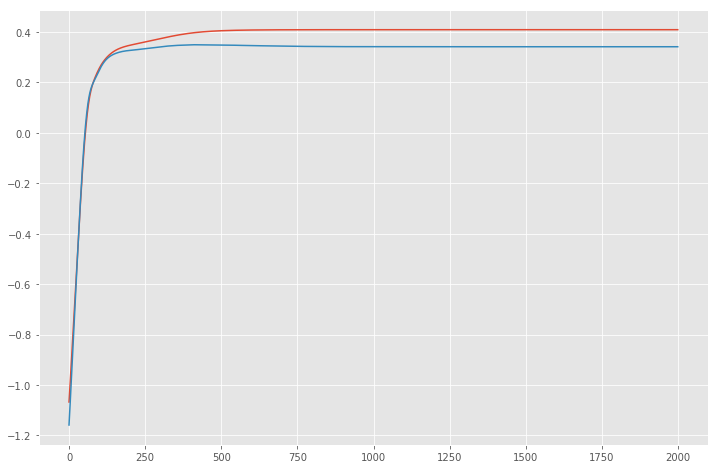

0.3418009335666863

In [335]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.show()


## Now lets do it again with the NLL function..

Now, lets alter the loss function to accomodate the censored behaviour of our observed data. The loss function for a one-limit tobit model can be defined as:

\begin{equation} 
lnL(\beta,\sigma) = \sum_{i=1}^n \left( d_i ln[\phi(\frac{y_i - x_i\beta}{\sigma})] - ln(\sigma) + (1-d_i) ln[1 - \Phi(\frac{y_i^* - x_i\beta}{\sigma}] \right)
\end{equation}

Where the indicator variable $d_i \in \{0,1\}$ is 1 if $y_i$ < $y_i*$, and 0 otherwise, and $\phi$ and $\Phi$ is the PDF and CDF of the standard normal distribution repectively.

Notice that our case is further complicated, since the upper limit y* is dynamicaly changing with the supply at the given time. 

In [367]:
#Notice that the cdf function easily overflows and evaluates to 1, meaning the loss function will go to infinity. 
#Therefore, to obtain a more stable solutions, we add an abritraty large number (20), if this occurs. 


def censored_NLL(output, labels, supply):
    x = torch.squeeze(output)
    di = get_numpy((labels == supply).float())
    loss = get_variable(Variable(torch.zeros(1)))
    for i in range(len(output)):
        if di[i] == 0:
            loss += -torch.log(standard_normal_pdf((labels[i]-x[i])/torch.std(labels)))
        if di[i] == 1:
            if get_numpy(labels[i]-x[i]) > 3.7:
                loss += 20
            else:
                loss += -torch.log(1-standard_normal_cdf((labels[i]-x[i])/torch.std(labels)))
    return loss

In [368]:
df['lag1'] = df.demand.shift(1)
df['lag2'] = df.demand.shift(2)
df['lag24'] = df.demand.shift(24)
df = df.iloc[24:].reset_index(drop=True)
df.head(6)

,Month,DoM,DoW,ToD,demand,supply,Fri,Mon,Sat,Sun,...,17,18,19,20,21,22,23,lag1,lag2,lag24
0,1,6,Sat,0,0,15,0,0,1,0,...,0,0,0,0,0,0,0,1.0,3.0,0.0
1,1,6,Sat,1,1,15,0,0,1,0,...,0,0,0,0,0,0,0,0.0,1.0,0.0
2,1,6,Sat,2,1,14,0,0,1,0,...,0,0,0,0,0,0,0,1.0,0.0,2.0
3,1,6,Sat,3,0,14,0,0,1,0,...,0,0,0,0,0,0,0,1.0,1.0,0.0
4,1,6,Sat,4,1,14,0,0,1,0,...,0,0,0,0,0,0,0,0.0,1.0,0.0
5,1,6,Sat,5,0,15,0,0,1,0,...,0,0,0,0,0,0,0,1.0,0.0,1.0


In [369]:
X = df.iloc[:,6:]
y = df.demand
z = df.supply

In [370]:
#Prepare data for training
X = np.asarray(X)
y = np.asarray(y)
z = np.asarray(z)

obs, num_features = X.shape
train_idx, val_idx = int(obs*0.8), int(obs*0.9)
x_train = X[:train_idx,:].astype('float32')
targets_train = y[:train_idx].astype('float32')
supply_train = z[:train_idx].astype('float32')

x_valid = X[train_idx:val_idx,:].astype('float32')
targets_valid = y[train_idx:val_idx].astype('float32')

x_test = X[val_idx:,:].astype('float32')
targets_test = y[val_idx:].astype('float32')



In [371]:
use_cuda = False

In [391]:
hidden = 126

class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        self.dense1 = Linear(in_features=num_features, out_features= hidden, bias=True)
        self.dense2 = Linear(in_features=hidden, out_features = num_features, bias = True)
        
        
        self.out = Linear(in_features = num_features, out_features = 1)
        
        self.dropout = nn.Dropout(0.4)
    def forward(self, x):
        
        x = self.dropout(relu(self.dense1(x)))
        x = relu(self.dense2(x))
        
        x = self.out(x)
        
        return x

model = Net()
if use_cuda:
    model.cuda()
print(model)

Net(
  (dense1): Linear(in_features=34, out_features=126)
  (dense2): Linear(in_features=126, out_features=34)
  (out): Linear(in_features=34, out_features=1)
  (dropout): Dropout(p=0.4)
)


In [392]:
l_rate = 0.001; optimiser = torch.optim.Adam(model.parameters(), lr = l_rate, weight_decay = 0.1) 
l_rate = 0.001; optimiser = optim.SGD(net.parameters(), lr=l_rate, weight_decay = 0.1) #R^2 ~ 0.357

criterion = censored_NLL
epochs = 200

AttributeError: module 'torch.optim' has no attribute 'SDG'

In [ ]:
train_acc = []
val_acc = []

for epoch in range(epochs):

    epoch +=1
    
    inputs = get_variable(Variable(torch.from_numpy(x_train).float()))
    labels = get_variable(Variable(torch.from_numpy(targets_train)).float())
    supply = get_variable(Variable(torch.from_numpy(supply_train)).float())
    
    optimiser.zero_grad()
    
    output = model.forward(inputs)
    ## Training with a normal MSE loss R^2 ~ 0.316
    #loss = criterion(output,labels)
    
    ##Training with our censored log-likelihood function - R^2 ~ 0.41  
    loss = criterion(output,labels,supply)
    
    loss.backward()
    optimiser.step()
    
    predicted = get_numpy(model.forward(get_variable(Variable(torch.from_numpy(x_train)))))
    predicted_val = get_numpy(model.forward(get_variable(Variable(torch.from_numpy(x_valid)))))
    
    train_acc.append(r2_score(targets_train, predicted))
    val_acc.append(r2_score(targets_valid, predicted_val))
    
    print('epoch {}, loss {}, accuracy {}, val_accuracy {}'.format(epoch,loss.data[0], train_acc[epoch-1], val_acc[epoch-1]))

In [378]:
predicted = get_numpy(model.forward(Variable(torch.from_numpy(x_valid))))
r2_score(targets_valid, predicted)

0.34332478208219785

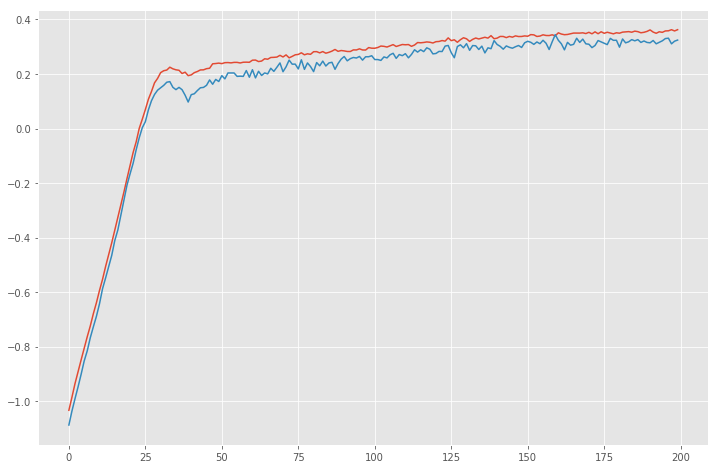

In [381]:
plt.plot(train_acc)
plt.plot(val_acc)
plt.show()

In [380]:
np.max(val_acc)

0.3443186343205532